In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

np.set_printoptions(suppress=True, precision=3)

sns.set(style='ticks', palette='Set2')
sns.despine()

In [2]:
c1, c2, c3, c4 = sns.mpl_palette('Set2', 4)
red_queen_color = c1
poisson_color = c2
oracle_color = c3
karimi_color = c4

red_queen_fmt = 's-'
oracle_fmt = 'd-'
poisson_fmt = 'o-'
karimi_fmt = '^-'

In [6]:
# %run -i options.py
%run -i utils.py
%run -i opt_model.py

In [7]:
from IPython.lib import deepreload

In [8]:
sim_opts = SimOpts.std_poisson(world_seed=42, world_rate=1000.0)
mgr = sim_opts.create_manager_with_opt(1)
mgr.run()
df = mgr.state.get_dataframe()
u_int_opt(df, sim_opts=sim_opts)

24.2522515977514

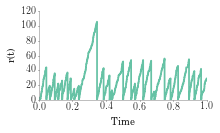

In [102]:
rank_count = rank_of_src_in_df(df, 1)
plt.step(rank_count.index, rank_count.mean(1), where='post')
plt.xlabel('Time')
plt.ylabel('r(t)')
plt.tight_layout()
format_axes(plt.gca())
latexify(fig_width=3.16, largeFonts=True)

In [103]:
[time_in_top_k(df, src_id=x, K=10, sim_opts=sim_opts) for x in sorted(df.src_id.unique())]

[0.25177123510846161, 1.0]

In [104]:
poisson_loss = calc_loss_poisson(df, u_const=u_int_opt(df, sim_opts=sim_opts), src_id=1, sim_opts=sim_opts)

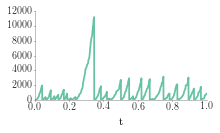

In [105]:
calc_loss_opt(df, sim_opts).plot()
plt.tight_layout()
format_axes(plt.gca())
latexify(columns=1, largeFonts=True)

# Synthetic experiments

In [9]:
%run -i options.py
%run -i utils.py
%run -i opt_model.py

In [18]:
%%time
sim_opts = SimOpts.std_poisson(world_seed=1 + 42, world_rate=10.0).update({ 'end_time': 100.0 })
tmp_kdd = worker_kdd((1, 567.0, 10, sim_opts, None, None))
tmp_poisson = worker_poisson((1, 567.0, sim_opts, None))
# tmp_oracle = worker_oracle((1, 567.0, 956, sim_opts, None))
# tmp_opt = worker_opt((1, sim_opts, None))

Done within 75 iterations!
Done within 696 iterations!
Done within 5306 iterations!
Done within 21661 iterations!
Done within 27250 iterations!
CPU times: user 15min 24s, sys: 323 ms, total: 15min 24s
Wall time: 15min 25s


In [5]:
%%time
sim_opts = SimOpts.std_piecewise_const(world_seed=1 + 42, 
                                       world_rates=np.arange(10) * 1.0,
                                       world_change_times=np.arange(10) * 10.0
                                      ).update({ 'end_time': 100.0 })
tmp_kdd = worker_kdd((1, 567.0, 9, sim_opts, None, None))
tmp_poisson = worker_poisson((1, 567.0, sim_opts, None))
# tmp_oracle = worker_oracle((1, 567.0, 956, sim_opts, None))
tmp_opt = worker_opt((1, sim_opts, None))

KeyboardInterrupt: 

In [22]:
tmp_kdd, tmp_poisson #, tmp_oracle, tmp_opt

({'avg_rank': 71.168424997482049,
  'avg_rank_1': 71.168424997482049,
  'avg_rank_10': 203.34746746143995,
  'avg_rank_20': 208.60555404195742,
  'avg_rank_3': 88.882515078230256,
  'avg_rank_5': 138.87975916174446,
  'avg_rank_k': 1,
  'kdd_opt_1': array([ 35.553,  33.872,  41.65 ,  58.911,  61.168,  76.685,  78.884,
          84.785,  95.492]),
  'kdd_opt_10': array([ 385.379,   22.145,   22.145,   22.147,   22.151,   22.296,
           22.42 ,   22.99 ,   25.327]),
  'kdd_opt_20': array([ 388.172,   22.353,   22.353,   22.353,   22.353,   22.353,
           22.353,   22.353,   22.353]),
  'kdd_opt_3': array([ 163.163,   16.859,   23.384,   39.962,   42.334,   60.521,
           63.277,   71.067,   86.432]),
  'kdd_opt_5': array([ 306.464,   10.498,   13.798,   24.602,   26.293,   39.132,
           41.16 ,   46.851,   58.203]),
  'kdd_opt_iters_1': 284,
  'kdd_opt_iters_10': 26815,
  'kdd_opt_iters_20': 27311,
  'kdd_opt_iters_3': 3988,
  'kdd_opt_iters_5': 15615,
  'r_2': 201.78194

In [56]:
%%time
sim_opts= SimOpts.std_hawkes(world_seed=1 + 42, world_lambda_0=1000.0, world_alpha=1.0, world_beta=10.0)
mgr = sim_opts.create_manager_for_wall()
mgr.run()

CPU times: user 747 ms, sys: 0 ns, total: 747 ms
Wall time: 745 ms


In [46]:
%%time
sim_opts = SimOpts.std_hawkes(world_seed=1 + 42, world_lambda_0=1000.0, world_alpha=1.0, world_beta=10.0)
worker_top_k_kdd((1, 3, 100.0, 10, sim_opts, None, None))

CPU times: user 5.59 s, sys: 0 ns, total: 5.59 s
Wall time: 5.59 s


In [3]:
%%time
import itertools as I
sim_opts = SimOpts(other_sources=[Poisson2(src_id=2, seed=seed, rate=1000.0)], 
                   end_time=100.0, 
                   src_id=1,
                   q_vec=q_vec,
                   s=s,
                   sink_ids=[1001],
                   edge_list=[(1, 1001), (2, 1001)])

with mp.Pool() as pool:
    N = 10
    K = 10
    seeds = range(0, N)
    seed_capacity = [None] * N
    opt_top_k_perf = [None] * N
    for idx, opt_dict in enumerate(pool.map(worker_top_k_opt,
                                            [(s, K, SimOpts.std_poisson(world_seed=s, world_rate=1000.0), None)
                                            for s in seeds])):
        seed_capacity[idx] = opt_dict['capacity']
        opt_top_k_perf[idx] = opt_dict['perf']
    
    poisson_top_k_perf = [None] * N
    for idx, poisson_dict in enumerate(pool.map(worker_top_k_poisson,
                                                [(s, K, seed_capacity[idx], 
                                                  SimOpts.std_poisson(world_seed=s, world_rate=1000.0), None)
                                                 for idx, s in enumerate(seeds)])):
        poisson_top_k_perf[idx] = poisson_dict['perf']

NameError: name 'seed' is not defined

# Inference new

In [430]:
%run -i opt_model.py

In [431]:
%run -i utils.py

In [432]:
Ks

[1]

In [433]:
poisson_inf_opts._get_dict()

{'N': 10,
 'T': 100.0,
 'log_s_high': 7.0,
 'log_s_low': -4.0,
 'num_segments': 10,
 'sim_opts_gen': <function __main__.<lambda>>,
 'world_alpha': 1.0,
 'world_beta': 10.0,
 'world_rate': 10.0}

In [468]:
%run -i utils.py

In [469]:
import warnings

In [1429]:
%%time

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    poisson_res_2 = run_inference_queue(opts=poisson_inf_opts)
    hawkes_res_2 = run_inference_queue(opts=hawkes_inf_opts)
    piecewise_res_2 = run_inference_queue(opts=piecewise_inf_opts)

*** 2016-08-05 17:16:34.732929 Checkpoint: active_procs = 220, procs = [('Opt', 38), ('Poisson', 60), ('kdd', 61), ('Oracle', 61)]
*** 2016-08-05 17:16:34.755297 Checkpoint: active_procs = 230, procs = [('Opt', 32), ('Poisson', 62), ('kdd', 68), ('Oracle', 68)]
*** 2016-08-05 17:16:34.772987 Checkpoint: active_procs = 230, procs = [('Opt', 30), ('Poisson', 62), ('kdd', 69), ('Oracle', 69)]
*** 2016-08-05 17:16:34.910721 Checkpoint: active_procs = 260, procs = [('Opt', 11), ('Poisson', 74), ('kdd', 87), ('Oracle', 88)]
*** 2016-08-05 17:16:34.991476 Checkpoint: active_procs = 270, procs = [('Opt', 4), ('Poisson', 75), ('kdd', 95), ('Oracle', 96)]
*** 2016-08-05 17:16:35.502979 Checkpoint: active_procs = 260, procs = [('Opt', 0), ('Poisson', 71), ('kdd', 89), ('Oracle', 100)]
*** 2016-08-05 17:16:36.299172 Checkpoint: active_procs = 250, procs = [('Opt', 0), ('Poisson', 68), ('kdd', 82), ('Oracle', 100)]
*** 2016-08-05 17:16:36.796866 Checkpoint: active_procs = 240, procs = [('Opt', 0), 

In [ ]:
worker_kdd((9, (opt_mgr.state.get_dataframe().src_id == sim_opts.src_id).sum() * 1.0, 10, sim_opts, None, None))

In [472]:
import pickle
import seqfile

In [445]:
def strip_sim_opts_from_raw_results(d):
    def rm_sim_opts(d_in):
        return {k: v for k, v in d_in.items() if k != 'sim_opts'}
    
    return {k: (v if k != 'raw_results' else [rm_sim_opts(x) for x in v]) 
            for k, v in poisson_res._get_dict().items()}
    

In [60]:
tmp = strip_sim_opts_from_raw_results(poisson_res._get_dict())

In [61]:
tmp.keys()

dict_keys(['capacities', 'raw_results', 'df'])

In [62]:
tmp['raw_results'][1].keys()

dict_keys(['world_events', 'capacity', 'seed', 'r_2', 'top_3', 'avg_rank', 'type', 's', 'num_events', 'top_5', 'top_1', 'top_20', 'top_10'])

In [219]:
with open(seqfile.findNextFile(prefix='synthetic-', suffix='.pickle'), 'wb') as pickle_file:
    pickle.dump({'poisson': strip_sim_opts_from_raw_results(poisson_res._get_dict()), 
                 'hawkes': strip_sim_opts_from_raw_results(hawkes_res._get_dict()), 
                 'piecewise': strip_sim_opts_from_raw_results(piecewise_res._get_dict())}, pickle_file)
    print('Wrote {}'.format(pickle_file.name))

Wrote ./synthetic-6.pickle


In [460]:
defined = False
try:
    poisson_res, hawkes_res, piecewise_res
    defined = True
except NameError:
    pass

confirmation = 'y'

if defined:
     confirmation = input('Some variables are already defined. Are you sure you want to clobber them? [Y/n]')
    
if confirmation.lower().startswith('y'):
    with open('synthetic-6.pickle', 'rb') as pickle_file:
        reloaded = pickle.load(pickle_file)

    poisson_res = Options(**reloaded['poisson'])
    hawkes_res = Options(**reloaded['hawkes'])
    piecewise_res = Options(**reloaded['piecewise'])
else:
    print('Cloberring averted.')

In [461]:
tmp = [x for x in poisson_res.raw_results if x['type'] == 'Opt']
tmp2 = pd.DataFrame.from_records(tmp)
np.sum(tmp2.capacity < tmp2.num_events) / tmp2.shape[0]

0.0

In [134]:
np.sum(tmp2.capacity), np.sum(tmp2.num_events)

(31781.458986215268, 31989)

In [88]:
tmp = poisson_res.df.pivot_table(index='s', columns='type', values='top_1', aggfunc=np.mean)

In [96]:
tmp = hawkes_res.df.pivot_table(index='s', columns='type', values='top_1', aggfunc=np.mean)

In [100]:
tmp = piecewise_res.df.pivot_table(index='s', columns='type', values='top_1', aggfunc=np.mean)

In [101]:
tmp['capacities'] = [np.mean([y for x, y in piecewise_res.capacities[s]]) for s in tmp.index]

In [102]:
tmp['Opt/Oracle'] = tmp['Opt'] / tmp['Oracle']

In [462]:
poisson_res.raw_results[0]

{'avg_rank': 8.8831368516445757,
 'capacity': 903.0,
 'num_events': 903,
 'r_2': 9.6861662248640243,
 's': 0.0001,
 'seed': 1,
 'top_1': 91.515699587139181,
 'type': 'Opt',
 'world_events': 992}

In [463]:
piecewise_res.capacities[piecewise_res.df.s[0]]

[(1, 903.0),
 (3, 930.0),
 (7, 867.0),
 (4, 930.0),
 (5, 893.0),
 (0, 905.0),
 (2, 898.0),
 (8, 957.0),
 (9, 910.0),
 (6, 957.0)]

In [94]:
tmp = [x for x in raw_results if x['type'] == 'kdd']

In [123]:
idx = len(tmp) - 1
tmp[idx]

{'kdd_opt': array([  64.382,   78.114,  101.586,  114.336,   76.14 ,   99.839,
          85.668,  127.037,   64.294,   94.166]),
 'perf': 0.84974391184022691,
 's': 1e-08,
 'seed': 9,
 'type': 'kdd'}

In [124]:
np.sum(tmp[idx]['kdd_opt'])

905.5634469866709

In [125]:
sim_opts = SimOpts.std_poisson(world_seed=tmp[idx]['seed'], world_rate=world_rate)
mgr = sim_opts.create_manager_for_piecewise_const(tmp[idx]['seed'], np.arange(num_segments) * (T / num_segments), 
                                                  tmp[idx]['kdd_opt'] / (T / num_segments))
mgr.run()

In [126]:
df = mgr.state.get_dataframe()

In [127]:
df[df.src_id == 1].shape

(933, 5)

In [60]:
world_changing_rates

array([ 6872.701,  9753.572,  8659.97 ,  7993.292,  5780.093,  5779.973,
        5290.418,  9330.881,  8005.575,  8540.363])

In [170]:
%run -i utils.py
%run -i opt_model.py

In [78]:
%%time
sim_opts = SimOpts.std_piecewise_const(world_seed=1, 
                                       world_change_times=world_change_times,
                                       world_rates=world_changing_rates  / 10.0)

*** 2016-05-06 23:17:36.775776 Checkpoint: s_lo = 0.5, s_hi = 1.0, num_events = 16 
*** 2016-05-06 23:17:36.822124 Checkpoint: s_lo = 0.25, s_hi = 0.5, num_events = 19 
*** 2016-05-06 23:17:36.865436 Checkpoint: s_lo = 0.125, s_hi = 0.25, num_events = 23 
*** 2016-05-06 23:17:36.908808 Checkpoint: s_lo = 0.0625, s_hi = 0.125, num_events = 29 
*** 2016-05-06 23:17:36.952059 Checkpoint: s_lo = 0.03125, s_hi = 0.0625, num_events = 38 
*** 2016-05-06 23:17:36.995332 Checkpoint: s_lo = 0.015625, s_hi = 0.03125, num_events = 44 
*** 2016-05-06 23:17:37.038704 Checkpoint: s_lo = 0.0078125, s_hi = 0.015625, num_events = 51 
*** 2016-05-06 23:17:37.038984 Checkpoint: s_lo = 0.0078125, s_hi = 0.015625
*** 2016-05-06 23:17:37.082146 Checkpoint: s_try = 0.01171875, events = 47, cost = 0.34094464338074343
*** 2016-05-06 23:17:37.125737 Checkpoint: s_try = 0.009765625, events = 51, cost = 0.29237130465832506
*** 2016-05-06 23:17:37.169080 Checkpoint: s_try = 0.0107421875, events = 48, cost = 0.31704

In [172]:
opt_oracle=find_opt_oracle(50.0, sim_opts, verbose=True)

*** 2016-05-07 01:47:38.712765 Checkpoint: s_lo = 1.0, s_hi = 2.0, num_events = 59 
*** 2016-05-07 01:47:43.295365 Checkpoint: s_lo = 2.0, s_hi = 4.0, num_events = 50 
*** 2016-05-07 01:47:47.877662 Checkpoint: s_lo = 4.0, s_hi = 8.0, num_events = 38 
*** 2016-05-07 01:47:47.877921 Checkpoint: s_lo = 4.0, s_hi = 8.0
*** 2016-05-07 01:47:52.475038 Checkpoint: s_try = 6.0, events = 43, cost = 190.24351658547735
*** 2016-05-07 01:47:57.100385 Checkpoint: s_try = 5.0, events = 44, cost = 167.86559770034106
*** 2016-05-07 01:48:01.686475 Checkpoint: s_try = 4.5, events = 47, cost = 156.45216699162305
*** 2016-05-07 01:48:06.268635 Checkpoint: s_try = 4.25, events = 48, cost = 150.4490239466958
*** 2016-05-07 01:48:10.907890 Checkpoint: s_try = 4.125, events = 49, cost = 147.34170023154488
*** 2016-05-07 01:48:15.692948 Checkpoint: s_try = 4.0625, events = 50, cost = 145.75934253252828


In [159]:
find_opt_oracle_time_top_k(50.0, sim_opts=sim_opts, K=3, tol=1e-2, verbose=True)

*** 2016-05-07 01:33:01.357070 Checkpoint: s_lo = 1.0, s_hi = 2.0, num_events = 59 
*** 2016-05-07 01:33:06.003020 Checkpoint: s_lo = 2.0, s_hi = 4.0, num_events = 50 
*** 2016-05-07 01:33:10.599267 Checkpoint: s_lo = 4.0, s_hi = 8.0, num_events = 38 
*** 2016-05-07 01:33:10.599564 Checkpoint: s_lo = 4.0, s_hi = 8.0
*** 2016-05-07 01:33:15.257199 Checkpoint: s_try = 6.0, events = 43, cost = 190.24351658547735
*** 2016-05-07 01:33:19.922371 Checkpoint: s_try = 5.0, events = 44, cost = 167.86559770034106
*** 2016-05-07 01:33:24.563932 Checkpoint: s_try = 4.5, events = 47, cost = 156.45216699162305
*** 2016-05-07 01:33:29.190108 Checkpoint: s_try = 4.25, events = 48, cost = 150.4490239466958
*** 2016-05-07 01:33:33.795787 Checkpoint: s_try = 4.125, events = 49, cost = 147.34170023154488
*** 2016-05-07 01:33:38.633058 Checkpoint: s_try = 4.0625, events = 50, cost = 145.75934253252828


0.18739408117276624

In [193]:
oracle_df = opt_oracle['df']
rb_mgr = sim_opts.create_manager_with_times(oracle_df.t[oracle_df.events == 1] + 1e-10)
rb_mgr.run()
df = rb_mgr.state.get_dataframe()
time_in_top_k(rb_mgr.state.get_dataframe(), K=3, sim_opts=sim_opts) 

0.24397405812513501

In [197]:
oracle_rank_calc = rank_of_src_in_df(df=df, src_id=1)

In [166]:
(df.src_id == 1).sum()

50

In [18]:
%run -i opt_model.py

In [39]:
%%time
s_opt = find_opt_oracle_s(100, sim_opt_gen(0).update({ 'end_time': 1.0 }), verbose=True)

*** 2016-05-06 00:18:23.087473 Checkpoint: s_lo = 0.5, s_hi = 1.0, num_events = 94 
*** 2016-05-06 00:18:28.610656 Checkpoint: s_lo = 0.25, s_hi = 0.5, num_events = 118 
*** 2016-05-06 00:18:28.611289 Checkpoint: s_lo = 0.25, s_hi = 0.5
*** 2016-05-06 00:18:34.356899 Checkpoint: s_try = 0.375, events = 104, cost = 28.115635566719792
CPU times: user 23.5 s, sys: 43.3 ms, total: 23.5 s
Wall time: 23.5 s


In [164]:
%%time
oracle_df = get_oracle_df(sim_opt_gen(0).update({'end_time': 1.0, 's': s_opt}))

CPU times: user 4.97 s, sys: 0 ns, total: 4.97 s
Wall time: 4.97 s


In [173]:
find_opt_oracle_time_top_k(100, 3, lambda: sim_opt_gen(0).update({'s': s_opt, 'end_time': 1.0}), verbose=True)

*** 2016-05-04 22:40:15.523984 Checkpoint: s_lo = 0.5, s_hi = 1.0, num_events = 95 
*** 2016-05-04 22:40:19.970286 Checkpoint: s_lo = 0.25, s_hi = 0.5, num_events = 120 
*** 2016-05-04 22:40:19.970578 Checkpoint: s_lo = 0.25, s_hi = 0.5
*** 2016-05-04 22:40:24.360491 Checkpoint: s_try = 0.375, events = 109, cost = 28.447623149728294


0.37156877786354015

In [129]:
%time
o, _ = (sim_opt_gen(0).update({ 's': 1e-3, 'end_time': 1.0 }))
o.events.sum()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 22.9 µs


582

In [130]:
%time
o, _ = worker_s(sim_opt_gen(0).update({ 's': 100, 'end_time': 1.0 }))
o.events.sum()

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 8.11 µs


17

In [133]:
%%time
sim_opts_generator = lambda : sim_opt_gen(0).update({ 'end_time': 1.0 })
s_try = find_ideal_s(100, sim_opts_generator)

*** 2016-05-04 20:05:22.158060 Checkpoint: s_lo = 0.5, s_hi = 1.0, num_tweets = 95 
*** 2016-05-04 20:05:30.702477 Checkpoint: s_lo = 0.25, s_hi = 0.5, num_tweets = 120 
*** 2016-05-04 20:05:30.702862 Checkpoint: s_lo = 0.25, s_hi = 0.5
*** 2016-05-04 20:05:39.416810 Checkpoint: s_try = 0.375, events = 109, cost = 28.447623149728294
CPU times: user 34.8 s, sys: 13.3 ms, total: 34.8 s
Wall time: 34.9 s


In [19]:
%%time
sim_opts = sim_opt_gen(0)
wall_mgr = sim_opts.create_manager_for_wall()
wall_mgr.run()
oracle_df = oracle_ranking(df=wall_mgr.state.get_dataframe(), 
                           sim_opts=sim_opt_gen(1))

KeyboardInterrupt: 

In [19]:
%%time
sim_opts = sim_opt_gen(0)
wall_mgr = sim_opts.create_manager_for_wall()
wall_mgr.run()
oracle_df = oracle_ranking(df=wall_mgr.state.get_dataframe(), 
                           sim_opts=sim_opt_gen(1))

KeyboardInterrupt: 

In [1447]:
@optioned(option_arg='opts')
def rank_plot(res, field, file_name, title=None, with_std=True, save=False, log_y=True, legend=False, fig_width=None, end_time=None):
    assert end_time is not None, "end_time must be specified."
    vals = res.df.pivot_table(index='s', columns='type', values=field, aggfunc=np.mean) / end_time
    std  = res.df.pivot_table(index='s', columns='type', values=field, aggfunc=np.std) / end_time
    
    if title is None:
        if field == 'avg_rank':
            title = 'Avg. rank'
        elif field == 'r_2':
            title = r'$\int r^2$dt'
        else:
            title = 'Unknown axis'
            
    if fig_width is None:
        fig_width = 1.75
        
    latexify(fig_width=fig_width, largeFonts=False)
    c1, c2, c3, c4 = sns.mpl_palette('Set2', 4)

    X = [np.mean(res.capacities[s]) for s in vals.index]
    plt.errorbar(X, vals.Opt, fmt='s-', yerr=std.Opt.values, label='RedQueen',  color=red_queen_color, markersize=3, linewidth=0.75)
    # plt.errorbar(X, vals.Poisson, fmt='o-', yerr=std.Poisson.values, label='Poisson', color=poisson_color, markersize=3, linewidth=0.75)
    plt.errorbar(X, vals.Oracle, fmt='d-', yerr=std.Oracle.values, label='Oracle', color=oracle_color, markersize=3, linewidth=0.75)
    plt.errorbar(X, vals.kdd, fmt='^-', yerr=std.kdd.values, label='Karimi', color=karimi_color, markersize=3, linewidth=0.75)
    
    plt.xscale('log')
    
    if log_y:
        plt.yscale('log')
        plt.yticks([10 ** i for i in [-1, 0, 1, 2]])
    
    if legend:
        plt.legend(loc="upper right")
        
    # plt.ylabel(title)
    plt.xlabel(r'Budget')
    # plt.ylim(None, 105)
    plt.xlim(4.5, None)
    plt.tight_layout()
    format_axes(plt.gca())
    
    if save:
        plt.savefig(file_name, bbox_inches='tight', pad_inches=0)
        
    # plt.savefig('/NL/stackexchange/work/prog/papers/online-twitter-broadcast/nips2016/figures/capacity-poisson-oracle-opt.pdf')
    # plt.savefig('/NL/stackexchange/work/prog/papers/online-twitter-broadcast/nips2016/figures/capacity-poisson-oracle-opt-kdd.pdf')

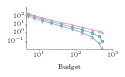

In [1445]:
rank_plot(hawkes_res_2, 'avg_rank', None, log_y=True, end_time=simulation_opts.T)

## Legend

### With Oracle

In [ ]:
fig = plt.figure()
figlegend = plt.figure(figsize=(4 * 2.0, 0.25))
ax = fig.add_subplot(111)
lines = [
    ax.plot(range(10), np.random.randn(10), red_queen_fmt, color=red_queen_color, markersize=3, linewidth=0.75)[0], 
    ax.plot(range(10), np.random.randn(10), oracle_fmt, color=oracle_color, markersize=3, linewidth=0.75)[0],
    ax.plot(range(10), np.random.randn(10), karimi_fmt, color=karimi_color, markersize=3, linewidth=0.75)[0]
]
figlegend.legend(tuple(lines), (r'\textsc{RedQueen}', 'Oracle', 'Karimi'), 'center', ncol=3)
figlegend.savefig('/NL/stackexchange/work/prog/papers/online-twitter-broadcast/wsdm2017/FIG/legend-with-oracle.pdf', 
                  bbox_inches='tight', pad_inches=0)

### With Poisson

In [ ]:

fig = plt.figure()
figlegend = plt.figure(figsize=(4 * 2.0, 0.25))
ax = fig.add_subplot(111)
lines = [
    ax.plot(range(10), np.random.randn(10), red_queen_fmt, color=red_queen_color, markersize=3, linewidth=0.75)[0], 
    # ax.plot(range(10), np.random.randn(10), poisson_fmt, color=poisson_color, markersize=3, linewidth=0.75)[0],
    ax.plot(range(10), np.random.randn(10), karimi_fmt, color=karimi_color, markersize=3, linewidth=0.75)[0]
]
#figlegend.legend(tuple(lines), (r'\textsc{RedQueen}', 'Poisson', 'Karimi'), 'center', ncol=3)
figlegend.legend(tuple(lines), (r'\textsc{RedQueen}', 'Karimi'), 'center', ncol=2)
figlegend.savefig('/NL/stackexchange/work/prog/papers/online-twitter-broadcast/wsdm2017/FIG/legend-with-poisson.pdf', 
                  bbox_inches='tight', pad_inches=0)

In [168]:
hawkes_res_higher_beta.df.pivot_table(index='s', columns='type', values='r_2', aggfunc=np.std)

type,Opt,Oracle,Poisson,kdd
s,,,,
1.000000e-08,0.004255,0.002257,0.377543,0.228007
1.000000e-07,0.013699,0.006435,0.708564,0.571351
1.000000e-06,0.058041,0.013762,1.468919,1.378015
1.000000e-05,0.229522,0.074677,4.076188,4.230126
1.000000e-04,0.866249,0.287207,9.320475,16.104886
1.000000e-03,3.766542,0.898753,25.476946,281.915090
1.000000e-02,16.224040,4.240223,87.953591,1259.529470
1.000000e-01,55.644573,20.417019,232.210492,2758.889224
1.000000e+00,218.081889,93.121546,1806.676547,10281.882413


In [ ]:
rank_plot(piecewise_res, 'avg_rank', None, legend=True, fig_width=8)

In [489]:
@optioned(option_arg='opts')
def top_k_plot(res, field, file_name, K=None, with_std=True, save=False, 
               legend=False, fig_width=None, largeFonts=False):
    vals = res.df.pivot_table(index='s', columns='type', values=field, aggfunc='mean')
    std  = res.df.pivot_table(index='s', columns='type', values=field, aggfunc=np.std)
    
    if K is None:
        assert field.startswith('top_')
        K = int(field[len('top_'):])

    if fig_width is None:
        fig_width = 1.75
        
    latexify(fig_width=fig_width, largeFonts=largeFonts)
    c1, c2, c3, c4 = sns.mpl_palette('Set2', 4)

    X = [np.mean(res.capacities[s]) for s in vals.index]
    plt.errorbar(X, vals.Opt, fmt=red_queen_fmt, yerr=std.Opt.values, label=r'\textsc{RedQueen}',  
                 color=red_queen_color, markersize=3, linewidth=0.75)
    # plt.errorbar(X, vals.Poisson, fmt=poisson_fmt, yerr=std.Poisson.values, label='Poisson', 
    #              color=poisson_color, markersize=3, linewidth=0.75)
    plt.errorbar(X, vals.Oracle, fmt=oracle_fmt, yerr=std.Oracle.values, label='Oracle',
                 color=oracle_color, markersize=3, linewidth=0.75)
    plt.errorbar(X, vals.kdd, fmt=karimi_fmt, yerr=std.kdd.values, label='Karimi', 
                 color=karimi_color, markersize=3, linewidth=0.75)
    plt.xscale('log')
    if legend:
        plt.legend(loc="upper left")
    # plt.ylabel(r'$\int {{I}}(r(t) < {})dt$'.format(K))
    plt.xlabel(r'Budget')
    plt.ylim(-5, 105)
    plt.yticks([0, 50, 100])
    plt.xlim(4.5, None)
    plt.tight_layout()
    format_axes(plt.gca())
    if save:
        plt.savefig(file_name, bbox_inches='tight', pad_inches=0)

In [183]:
piecewise_res.df.pivot_table(index='s', columns='type', values='top_1')

type,Opt,Oracle,Poisson
s,,,
0.000001,99.265603,99.887749,49.569384
0.000010,97.735429,99.869711,49.208997
0.000100,93.345349,99.660187,47.966030
0.001000,82.502168,98.137780,44.832798
0.010000,63.741640,90.497193,38.301633
0.100000,42.604444,69.574702,29.793909
1.000000,26.399126,45.733009,20.522375
10.000000,15.394732,29.057503,13.122382
100.000000,8.592110,17.542691,8.255395


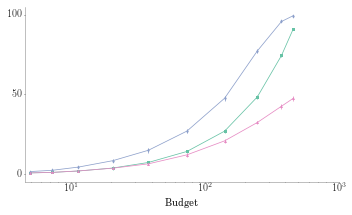

In [480]:
top_k_plot(poisson_res_2, 'top_1', '/tmp/test.pdf', save=False, fig_width=5, largeFonts=True)

In [188]:
poisson_res_2.df.columns

Index(['avg_rank', 'num_events', 'r_2', 's', 'seed', 'top_1', 'type',
       'world_events'],
      dtype='object')

In [250]:
tmp = poisson_res_2.df
tmp[tmp.type == 'Poisson'].describe()

,avg_rank,num_events,r_2,s,seed,top_1,top_5,world_events
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,3775.626447,271.450000,930276.062968,1063771.421300,4.500000,16.792321,45.866765,998.400000
std,6877.641685,318.522294,3746813.663833,2999066.878561,2.886751,17.185526,36.256616,24.631424
min,101.417892,0.000000,286.276565,0.000100,0.000000,0.000000,0.525209,956.000000
25%,205.294872,18.750000,1026.565139,0.027826,2.000000,1.726655,9.158226,980.000000
50%,937.210705,102.000000,17952.364853,68.448802,4.500000,8.554189,38.553385,993.500000
75%,4467.226670,494.750000,355991.808174,35938.136638,7.000000,32.230900,85.744226,1022.000000
max,51602.111467,963.000000,34894547.293472,10000000.000000,9.000000,49.635027,97.436874,1035.000000


In [251]:
tmp = hawkes_res_2.df
tmp[tmp.type == 'Poisson'].describe()

,avg_rank,num_events,r_2,s,seed,top_1,top_5,world_events
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,4620.816542,301.930000,1435908.914914,1063771.421300,4.500000,16.515543,44.783209,1155.500000
std,8514.776225,360.750124,5029173.581471,2999066.878561,2.886751,17.136917,36.462044,33.881105
min,94.909487,0.000000,281.466563,0.000100,0.000000,0.000000,0.138730,1113.000000
25%,217.732407,20.500000,1139.069265,0.027826,2.000000,1.706495,9.025254,1126.000000
50%,1071.553104,111.500000,23536.617241,68.448802,4.500000,8.259371,36.931077,1147.000000
75%,4980.140291,529.500000,416858.523927,35938.136638,7.000000,30.852401,85.071333,1198.000000
max,56634.343917,1087.000000,42792074.660449,10000000.000000,9.000000,51.374306,97.641337,1207.000000


In [253]:
tmp = piecewise_res_2.df
tmp[tmp.type == 'Poisson'].describe()

,avg_rank,num_events,r_2,s,seed,top_1,top_5,world_events
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,2999.325583,220.010000,565300.529805,1063771.421300,4.500000,18.048286,48.686186,754.700000
std,5323.113679,249.077023,2132068.274656,2999066.878561,2.886751,17.429374,35.935099,25.085913
min,93.517316,0.000000,245.415447,0.000100,0.000000,0.000000,0.565336,715.000000
25%,184.210533,18.000000,865.050901,0.027826,2.000000,2.726000,12.729771,736.000000
50%,763.677975,93.500000,13713.628282,68.448802,4.500000,11.058082,45.657781,749.000000
75%,3559.701735,412.500000,210573.253905,35938.136638,7.000000,34.647645,88.574192,776.000000
max,39128.203550,743.000000,19743325.457668,10000000.000000,9.000000,50.042244,98.029689,799.000000


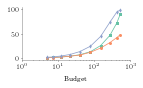

In [249]:
top_k_plot(hawkes_res_2, 'top_1', None)

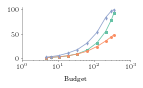

In [252]:
top_k_plot(piecewise_res_2, 'top_1', '/tmp/test.pdf', save=False)

## Plots

In [ ]:
import os
# base = '/NL/stackexchange/work/prog/papers/online-twitter-broadcast/nips2016/figures/'

In [ ]:
poisson_res.raw_results[0]

In [1451]:
%%time
plot_base = '/NL/stackexchange/work/prog/papers/online-twitter-broadcast/wsdm2017/FIG/'
for name, res in [('poisson', poisson_res_2), ('hawkes', hawkes_res_2)]: # , ('piecewise', piecewise_res_2)]:
    file_name = os.path.join(plot_base, 'avg-rank-{}-wall.pdf'.format(name))
    rank_plot(res, 'avg_rank', file_name, save=True, end_time=simulation_opts.T)
    plt.close()
    
    file_name = os.path.join(plot_base, 'r2-{}-wall.pdf'.format(name))
    rank_plot(res, 'r_2', file_name, save=True, end_time=simulation_opts.T)
    plt.close()
    
    file_name = os.path.join(plot_base, 'r2-{}-wall-linear.pdf'.format(name))
    rank_plot(res, 'r_2', file_name, save=True, log_y=False, end_time=simulation_opts.T)
    plt.close()
    
    file_name = os.path.join(plot_base, 'avg-rank-{}-wall-linear.pdf'.format(name))
    rank_plot(res, 'avg_rank', file_name, save=True, log_y=False, end_time=simulation_opts.T)
    plt.close()
    
    for k in [1]:
        file_name = os.path.join(plot_base, 'top-{}-{}-wall.pdf'.format(k, name))
        top_k_plot(res, 'top_{}'.format(k), file_name, save=True)
        plt.close()

CPU times: user 10.3 s, sys: 47.5 s, total: 57.7 s
Wall time: 1min 55s


In [1423]:
poisson_res_2.df.ix[392, :]

avg_rank            10141.6
num_events                4
r_2             1.39772e+06
s                     1e+07
seed                      4
top_1               1.03397
type                 Oracle
world_events           1028
Name: 392, dtype: object

In [146]:
simulation_opts.world_beta

2.0

In [79]:
%run -i opt_model.py

In [33]:
%%time
def plot_intensity(sim_opts, name):
    wall_mgr = sim_opts.create_manager_for_wall()
    wall_mgr.run()
    assert len(wall_mgr.sources) == 1
    broadcaster = wall_mgr.sources[0]
    X = np.linspace(start=0, stop=sim_opts.end_time, num=100)
    Y = [broadcaster.get_rate(t) for t in X]
    latexify(columns=1, largeFonts=False)
    plt.plot(X, Y)
    plt.xlabel('Time')
    plt.ylabel(r'$\lambda(t)$')
    plt.title('Sample intensity of {} wall'.format(name))
    plt.tight_layout()
    format_axes(plt.gca())

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 52.9 µs


CPU times: user 2.45 s, sys: 457 ms, total: 2.91 s
Wall time: 7.08 s


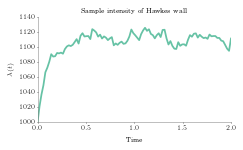

In [34]:
%%time
plot_intensity(SimOpts.std_hawkes(world_seed=1, 
                                  world_beta=10, 
                                  world_alpha=1, 
                                  world_lambda_0=1000).update({'end_time': 2}),
               'Hawkes')

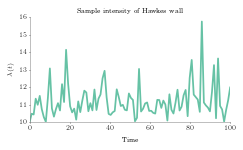

In [236]:
plot_intensity(hawkes_inf_opts.sim_opts_gen(5), 'Hawkes')
plt.savefig(os.path.join(plot_base, 'hawkes_intensity.pdf'), bbox_inches='tight', pad_inches=0)

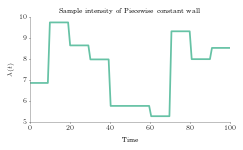

In [237]:
plot_intensity(piecewise_inf_opts.sim_opts_gen(5), 'Piecewise constant')
plt.savefig(os.path.join(plot_base, 'piecewise_const_intenstiy.pdf'),  bbox_inches='tight', pad_inches=0)

In [194]:
%run -i utils.py

In [195]:
sim_opts = SimOpts.std_hawkes(world_seed=101, world_lambda_0=0
wall_mgr = sim_opts.create_manager_for_wall()
wall_mgr.run()
df = wall_mgr.state.get_dataframe()

In [196]:
%time or_new, J_new = oracle_ranking_new(df=df, sim_opts=sim_opts)

CPU times: user 5.42 s, sys: 3.33 ms, total: 5.42 s
Wall time: 5.42 s


In [197]:
%time or_old, J_old = oracle_ranking(df=df, sim_opts=sim_opts)

CPU times: user 4.91 s, sys: 3.33 ms, total: 4.91 s
Wall time: 4.91 s


## Compare against Mohammed's method

In [47]:
import broadcast.data as Bdata
import broadcast.opt.optimizer as Bopt

In [127]:
reload(Bopt)

<module 'broadcast.opt.optimizer' from '/NL/stackexchange/work/prog/broadcast_ref/broadcast/opt/optimizer.py'>

In [423]:
world_rate = 1.0
num_segments = 10
K = 1
T = 1000.0

rs = np.random.RandomState(42)
low_high_ratio = 0.75
world_rates = rs.uniform(low=world_rate * (1 - low_high_ratio),
                         high=world_rate * (1 + low_high_ratio), 
                         size=num_segments)

# wall_mgr = (SimOpts.std_poisson(world_rate=world_rate, world_seed=0)
sim_opts = (SimOpts.std_piecewise_const(world_seed=1, world_rates=world_rates, 
                                        world_change_times=np.arange(num_segments) / num_segments * T)
            .update({ 'end_time': T }))
wall_mgr = sim_opts.create_manager_for_wall()
wall_mgr.run()

wall_df = wall_mgr.state.get_dataframe()
wall_intensities = wall_df.groupby((wall_df.t.values / T * num_segments).astype(int)).size() / (T / num_segments)
# wall_intensities = np.asarray([1000] * num_segments)
# wall_intensities = world_rates

follower_wall_intensities = np.array([wall_intensities])
follower_conn_prob = np.array([[1.0] * num_segments])
follower_weights = np.array([1.0])

def _util(x):
    return Bopt.utils.weighted_top_k(x, follower_wall_intensities, follower_conn_prob, follower_weights, K)

def _util_grad(x):
    return Bopt.utils.weighted_top_k_grad(x, follower_wall_intensities, follower_conn_prob, follower_weights, K)

x0 = np.ones(num_segments)
budget = 100.0
upper_bounds = np.array([1e6] * num_segments)
threshold=0.005 # Relative tolerance for convergence

kdd_opt = Bopt.optimize(util=_util, 
                        util_grad=_util_grad, 
                        budget=budget, 
                        upper_bounds=upper_bounds, 
                        threshold=threshold, 
                        x0=x0, verbose=True)

Done within 5 iterations!


In [424]:
kdd_opt

array([ 13.006,  11.875,  11.446,  10.409,   7.556,   7.694,   6.336,
        10.98 ,  10.131,  10.566])

In [425]:
Bopt.utils.weighted_top_k(kdd_opt, follower_wall_intensities, follower_conn_prob, follower_weights, K)

9.0242120830208776

In [ ]:
worker_kdd((0, 100.0, 10, sim_opts, world_rates, None))

In [79]:
sim_opts = SimOpts.std_piecewise_const(world_seed=0, world_change_times=np.arange(num_segments) * (T / num_segments), 
                                       world_rates=kdd_opt * 10)

In [80]:
wall_mgr = sim_opts.create_manager_for_wall()

In [81]:
wall_mgr.run()

In [82]:
df = wall_mgr.state.get_dataframe()

In [323]:
df = poisson_res_2.df

In [327]:
df.pivot_table(index='s', values='top_1', columns='type', aggfunc=np.mean)

type,Opt,Oracle,Poisson,kdd
s,,,,
0.000100,91.364467,99.530182,47.734702,47.548313
0.001668,74.431284,95.823468,42.211243,42.247671
0.027826,48.361404,77.298801,32.127741,32.245158
0.464159,26.834463,47.551197,20.918398,20.817688
7.742637,14.073225,26.895195,12.083601,12.077850
129.154967,7.127160,14.792741,6.289259,6.210012
2154.434690,3.614960,8.241672,3.605528,3.610374
35938.136638,1.749342,4.215994,1.675942,1.849785
599484.250319,0.874652,2.175858,0.831468,0.878096


In [326]:
df.pivot_table(index='s', values='top_1', columns='type', aggfunc=np.std)

type,Opt,Oracle,Poisson,kdd
s,,,,
0.000100,0.327185,0.114165,1.594643,1.262253
0.001668,0.735968,0.310643,1.473769,1.634483
0.027826,0.994214,1.228987,1.667879,1.215967
0.464159,1.055291,1.663420,1.262969,1.473501
7.742637,1.185131,1.439466,1.416186,1.258427
129.154967,0.656280,1.413249,0.762736,0.815361
2154.434690,0.981349,0.770348,0.568365,0.562886
35938.136638,0.695556,0.691490,0.439283,0.637002
599484.250319,0.342350,0.516736,0.480644,0.349610


## Find the q_vec which provides a certain capacity

In [134]:
%run -i opt_model.py

In [227]:
%%time
sim_opts = SimOpts(**{ 
        'src_id': 1,
        'end_time': 100.0,
        'q_vec': np.asarray([1.0]),
        'other_sources': [Poisson(src_id=2, seed=1, rate=10000.0)],
        's': 1.0,
        'sink_ids': [1001],
        'edge_list': [(1, 1001), (2, 1001)]
    })
# tmp = calc_q_capacity_iter(sim_opts)
tmp3_poisson_1 = calc_q_capacity_iter(sim_opts)

CPU times: user 110 ms, sys: 157 ms, total: 267 ms
Wall time: 2min 48s


In [228]:
tmp3_poisson_1.mean()

7967.1629870452907

In [229]:
%run -i opt_model.py

In [230]:
%%time
sim_opts = SimOpts(**{ 
        'src_id': 1,
        'end_time': 100.0,
        'q_vec': np.asarray([1.0]),
        'other_sources': [Poisson2(src_id=2, seed=1, rate=10000.0)],
        's': 1.0,
        'sink_ids': [1001],
        'edge_list': [(1, 1001), (2, 1001)]
    })
# tmp = calc_q_capacity_iter(sim_opts)
tmp3_poisson_2 = calc_q_capacity_iter(sim_opts)

CPU times: user 83.3 ms, sys: 113 ms, total: 197 ms
Wall time: 2min 7s


In [231]:
tmp3_poisson_2.mean()

7960.4575864000271

In [174]:
np.random.uniform(10)

1.4617278497435535

In [153]:
tmp2

0.99971767328613059

In [97]:
%%time
tmp2 = calc_q_capacity_iter(sim_opts, parallel=True)

CPU times: user 40 ms, sys: 367 ms, total: 407 ms
Wall time: 16.7 s


In [103]:
tmp4 = calc_q_capacity_iter(sim_opts.update({ 's': 2.0 }), parallel=True)

In [104]:
tmp4.mean()

2110.2250458304434

In [145]:
%run -i utils.py

In [238]:
sim_opts = SimOpts(**{ 
        'src_id': 1,
        'end_time': 100.0,
        'q_vec': np.asarray([1.0]),
        # 'other_sources': [Poisson2(src_id=2, seed=1, rate=10000.0)],
        'other_sources': [Poisson(src_id=2, seed=1, rate=10000.0)],
        's': 1.0,
        'sink_ids': [1001],
        'edge_list': [(1, 1001), (2, 1001)]
    })

In [148]:
%%time
s_opt = sweep_s(lambda: SimOpts.std_poisson(world_seed=1, world_rate=100.0), capacity_cap=100.0, verbose=True)

*** 2016-05-04 21:59:44.864163 Checkpoint: Initial capacity = 769.0321811055888
*** 2016-05-04 22:00:06.321337 Checkpoint: s_hi = 4096.0, s_lo = 2048.0
*** 2016-05-04 22:00:07.986757 Checkpoint: new_capacity = 106.16027670602416, s = 3072.0
*** 2016-05-04 22:00:09.666732 Checkpoint: new_capacity = 101.194622540465, s = 3584.0
*** 2016-05-04 22:00:11.336612 Checkpoint: new_capacity = 99.42532014279948, s = 3840.0
CPU times: user 210 ms, sys: 2.12 s, total: 2.33 s
Wall time: 28.5 s


In [149]:
s_opt

3840.0

In [239]:
%%time
# This is with Poisson: Took ~ 47min, 44s
s_opt = sweep_s(sim_opts, 50000.0, verbose=True)

*** 2016-05-02 00:12:20.257822 Checkpoint: Initial capacity = 7967.162987045291
*** 2016-05-02 00:44:22.309096 Checkpoint: s_hi = 0.0009765625, s_lo = 0.00048828125
*** 2016-05-02 00:46:56.892996 Checkpoint: new_capacity = 47736.13035565209, s = 0.000732421875
*** 2016-05-02 00:49:32.194914 Checkpoint: new_capacity = 49913.7414199194, s = 0.0006103515625
*** 2016-05-02 00:52:06.251847 Checkpoint: new_capacity = 51218.96161754592, s = 0.00054931640625
*** 2016-05-02 00:54:41.662719 Checkpoint: new_capacity = 50540.20193159806, s = 0.000579833984375
*** 2016-05-02 00:57:16.650763 Checkpoint: new_capacity = 50224.656253556066, s = 0.0005950927734375
CPU times: user 1.96 s, sys: 2.18 s, total: 4.14 s
Wall time: 47min 44s


In [233]:
%%time
# This was with Poisson2: Took ~ 35min, 24s
s_opt = sweep_s(sim_opts, 50000.0, verbose=True)

*** 2016-05-01 22:57:44.982005 Checkpoint: Initial capacity = 7960.457586400027
*** 2016-05-01 23:21:25.507846 Checkpoint: s_hi = 0.0009765625, s_lo = 0.00048828125
*** 2016-05-01 23:23:19.044300 Checkpoint: new_capacity = 47686.2063074488, s = 0.000732421875
*** 2016-05-01 23:25:12.821979 Checkpoint: new_capacity = 49871.05306762598, s = 0.0006103515625
*** 2016-05-01 23:27:08.958602 Checkpoint: new_capacity = 51169.0749459018, s = 0.00054931640625
*** 2016-05-01 23:29:03.197845 Checkpoint: new_capacity = 50501.14818392287, s = 0.000579833984375
*** 2016-05-01 23:30:57.014591 Checkpoint: new_capacity = 50177.111303157675, s = 0.0005950927734375
CPU times: user 1.58 s, sys: 2.26 s, total: 3.84 s
Wall time: 35min 24s


In [135]:
s_opt

2.5033950805664062e-06

In [132]:
s_opt

2.503393943698029e-06

### Micro-benchmark: fastest poisson

In [201]:
def foo(T):
    rs = np.random.RandomState(42)
    t, dt = 0, 0
    n = 0
    while t + dt < T:
        t = t + dt
        n += 1
        dt = rs.exponential(1 / 1000.0)
    return t, n

def bar(T):
    rs = np.random.RandomState(42)
    n = rs.poisson(1000.0 * T)
    last_time = sorted(rs.uniform(high=T, size=n))[-1]
    return last_time, n


In [204]:
%timeit tmp1 = foo(1000)

1 loop, best of 3: 394 ms per loop


In [205]:
%timeit tmp2 = bar(1000)

1 loop, best of 3: 829 ms per loop


In [206]:
foo(1000), bar(1000)

((999.999833196945, 998932), (999.99831486095445, 999640))

In [245]:
%%time
import itertools as I

def worker(param):
    return np.sum(range(param * 10000000))

def foo(params):
    start, stop = params
    total = 0
    with mp.Pool() as pool:
        for s in pool.imap_unordered(worker, range(start, stop)):
            total += s
    return start, stop, total

# Does not work with 'Pool' class because "daemonic processes are not allowed to have children"
with mp.pool.ThreadPool() as pool:
    for start, stop, t in pool.imap_unordered(foo, zip(range(1, 10), range(100, 110))):
        print('start, stop, t = ', start, stop, t)
        
        
        

KeyboardInterrupt: 

## Multiple followers

Increase the number of followers and see the improvements wrought about by RedQueen.

There should be a set of ~ 100 broadcasters and all the followers choose their broadcaster by preferential attachment.

In [8]:
import decorated_options as Deco

In [414]:
from opt_runs import make_piecewise_const

In [404]:
%timeit make_piecewise_const(10)

The slowest run took 4.84 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 641 µs per loop


In [421]:
tmp_segs = 1000
tmp_make_piecewise_const = make_piecewise_const(tmp_segs)
np.asarray(tmp_make_piecewise_const).sum() * 1/tmp_segs * np.pi

1.9997315530842155

In [ ]:
plt.plot(tmp_make_piecewise_const, 'o-')

In [48]:
tmp_make_edge_list = make_edge_list(opts=mk_edge_list_opts)

In [49]:
tmp_make_edge_list[0:5]

[(5037, 1000), (5095, 1000), (5073, 1000), (5059, 1000), (5015, 1000)]

In [323]:
from opt_runs import multiple_follower_opts, prepare_multiple_followers_sim_opts

In [324]:
sim_opts = prepare_multiple_followers_sim_opts(num_followers=10, opts=multiple_follower_opts)

In [325]:
len(sim_opts.get_dict()['other_sources'])

10

In [326]:
opt_mgr = sim_opts.create_manager_with_opt(42)

In [327]:
%%time
opt_mgr.run_dynamic()

CPU times: user 4.48 s, sys: 23.3 ms, total: 4.5 s
Wall time: 4.51 s


In [328]:
opt_df = opt_mgr.get_state().get_dataframe()

In [329]:
wall_df = opt_df[opt_df.src_id != sim_opts.src_id]

In [330]:
T = sim_opts.end_time
num_segments = 24
seg_idx = (wall_df.t.values / T * num_segments).astype(int)
wall_intensities = wall_df.groupby(seg_idx).size() / (T / num_segments)

In [331]:
intensity_df = (wall_df.groupby(['sink_id', pd.Series(seg_idx, name='segment')]).size() / (T / num_segments)).sort_index()

In [332]:
world_intensities = \
    intensity_df.reset_index('segment', name='intensity').reset_index('sink_id').pivot_table(
        values='intensity', index='sink_id', columns='segment').ix[sim_opts.sink_ids[::-1]]

In [333]:
opt_df[opt_df.src_id == 1].t.nunique()

791

In [334]:
%%time
poisson_results = worker_poisson((42, float(opt_df[opt_df.src_id == 1].t.nunique()), 
                                  sim_opts, None))

CPU times: user 1.81 s, sys: 50 ms, total: 1.86 s
Wall time: 1.86 s


In [ ]:
poisson_results

In [336]:
%%time
kdd_results = worker_kdd((42, float(opt_df[opt_df.src_id == 1].t.nunique()), 
                          24, sim_opts, world_intensities, None))

CPU times: user 2.13 s, sys: 23.3 ms, total: 2.16 s
Wall time: 2.15 s


utils.py:726: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  follower_weights)


In [ ]:
kdd_results

In [338]:
%%time
opt_results = worker_opt((42, sim_opts, 24, None))

CPU times: user 5.09 s, sys: 83.3 ms, total: 5.17 s
Wall time: 5.17 s


In [ ]:
opt_results

In [482]:
%run -i utils.py

In [483]:
import decorated_options as Deco
import warnings

In [ ]:
%%time
new_multiple_follower_opts = \
    Deco.Options(repetitions=200, num_followers_list=list(range(1, 15)),
                 num_segments=24,  # This matches with the number of segments the rate of users is divided in
                 setup_opts=multiple_follower_opts)
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    run_multiple = run_multiple_followers(opts=new_multiple_follower_opts)
    run_multiple_df = run_multiple.df

*** 2016-07-31 20:56:37.505843 Checkpoint: active/total = 3798/1000, procs = [('Opt', 1800), ('Poisson', 999), ('kdd', 999)]
*** 2016-07-31 20:58:04.241126 Checkpoint: active/total = 4798/2000, procs = [('Opt', 800), ('Poisson', 1999), ('kdd', 1999)]
*** 2016-07-31 20:59:26.175975 Checkpoint: active/total = 5386/3000, procs = [('Opt', 7), ('Poisson', 2687), ('kdd', 2692)]
*** 2016-07-31 21:00:34.287421 Checkpoint: active/total = 4400/4000, procs = [('Opt', 0), ('Poisson', 2198), ('kdd', 2202)]
*** 2016-07-31 21:01:26.155561 Checkpoint: active/total = 3400/5000, procs = [('Opt', 0), ('Poisson', 1698), ('kdd', 1702)]
*** 2016-07-31 21:02:19.702793 Checkpoint: active/total = 2400/6000, procs = [('Opt', 0), ('Poisson', 1196), ('kdd', 1204)]


In [354]:
list(filter(lambda x : x['type'] == 'kdd', run_multiple.raw_results))

[{'avg_rank': 1941.8356066549536,
  'avg_rank_1': 1941.8356066549536,
  'avg_rank_k': 1,
  'kdd_opt_1': array([ 39.483,  43.113,  45.229,  43.067,  29.339,  27.505,  41.563,
          44.869,  42.969,  40.445,  35.253,  32.741,  28.504,  21.504,
          19.007,  15.087,  17.098,  19.532,  14.992,  19.788,  25.087,
          27.944,  27.706,  34.172]),
  'kdd_opt_iters_1': 77,
  'num_events': 671,
  'r_2': 103566.18716409168,
  'r_2_1': 103566.18716409168,
  'r_2_k': 1,
  's': 1.0,
  'seed': 391,
  'sim_opts': <__main__.SimOpts at 0x7f2024cb8a58>,
  'top_1': 11.167303292697587,
  'top_1_num_events': 671,
  'type': 'kdd',
  'world_events': 9962},
 {'avg_rank': 1500.7462124566723,
  'avg_rank_1': 1500.7462124566723,
  'avg_rank_k': 1,
  'kdd_opt_1': array([ 38.87 ,  42.471,  44.742,  42.841,  29.151,  27.318,  41.196,
          44.419,  42.507,  40.143,  34.678,  31.903,  27.53 ,  21.05 ,
          18.031,  14.503,  16.209,  18.558,  13.342,  18.513,  23.879,
          27.054,  26.811, 

In [1454]:
(9.578593 - 11.774446) / 11.774446

-0.18649310549303125

In [1452]:
run_multiple_df.groupby(['type', 'num_followers']).mean()

avg_rank  num_events           r_2    s  seed  \
type    num_followers                                                     
Opt     1               739.178485     740.450   9929.478364    1  4234   
        2               758.088181     756.820  10057.857737    4  4234   
        3               767.843128     770.410   9974.780727    9  4234   
        4               779.612632     781.875   9998.569799   16  4234   
        5               791.228205     791.295  10031.004842   25  4234   
        6               789.648420     790.660  10003.279903   36  4234   
        7               791.488058     794.075   9990.471661   49  4234   
        8               791.784455     793.260   9993.457307   64  4234   
        9               792.629421     794.165   9980.121863   81  4234   
        10              791.718174     792.205   9975.372412  100  4234   
        11              791.995977     791.860   9979.692281  121  4234   
        12              791.373179     790.870   9987.138560  144  4234   
        13              792.049248     792.570   9981.199959  169  4234   
        14              792.685469     791.885   9999.907473  196  4234   
Poisson 1              1345.026473     736.375  45798.027055    1  4234   
        2              1326.388681     752.315  43662.814957    4  4234   
        3              1302.113664     766.075  40603.657258    9  4234   
        4              1288.157546     777.725  37538.261627   16  4234   
        5              1273.959990     787.125  33990.291850   25  4234   
        6              1271.609458     786.500  34124.939228   36  4234   
        7              1265.647739     789.905  33126.614017   49  4234   
        8              1267.239716     788.675  33344.388504   64  4234   
        9              1263.871247     790.025  32870.856437   81  4234   
        10             1265.641916     788.065  33249.746327  100  4234   
        11             1265.630654     787.480  33217.620402  121  4234   
        12             1267.182280     786.725  33584.733011  144  4234   
        13             1265.304407     787.990  33261.640583  169  4234   
        14             1267.933040     787.280  33505.811196  196  4234   
kdd     1              1713.980032     737.215  94956.797307    1  4234   
        2              1693.758075     753.895  92692.473752    4  4234   
        3              1586.010842     767.060  75649.157586    9  4234   
        4              1445.380461     778.785  55062.565491   16  4234   
        5              1302.912902     786.265  36691.824778   25  4234   
        6              1312.500955     786.875  37962.514059   36  4234   
        7              1292.959475     789.720  35586.180911   49  4234   
        8              1298.751045     789.805  36541.692962   64  4234   
        9              1284.186760     790.085  34753.283282   81  4234   
        10             1298.987563     787.795  36304.993468  100  4234   
        11             1306.968520     787.845  37142.450596  121  4234   
        12             1314.007920     786.835  38126.408711  144  4234   
        13             1308.146478     789.280  37467.461600  169  4234   
        14             1306.878396     787.910  37371.122971  196  4234   

                           top_1  world_events  
type    num_followers                           
Opt     1               9.578593          9962  
        2               9.658950         20048  
        3              10.931668         30018  
        4              11.606586         40150  
        5              12.368835         50191  
        6              12.276743         60074  
        7              12.409365         70103  
        8              12.427936         80086  
        9              12.491009         90033  
        10             12.378370         99949  
        11             12.392811        109943  
        12             12.327947        119938  
        13             12.367304       

In [1455]:
def plot_multiple_followers_perf(run_multiple_df, measure='avg_rank', 
                                 yticks=None,
                                 file_name=None):
    run_multiple_df = run_multiple_df.sort_values(['type', 'num_followers'])
    perf_data_grp = run_multiple_df.groupby(['type', 'num_followers'])
    perf_mean = perf_data_grp.mean()
    perf_std = perf_data_grp.std()
    
    # plt.figure(figsize=(8,6))
    
    if file_name is None:
        latexify(fig_width=8, largeFonts=True)
    else:
        latexify(fig_width=1.75, largeFonts=False)
    
    num_followers = np.asarray(sorted(run_multiple_df.num_followers.unique().tolist()))
    c1, c2, c3 = sns.color_palette('Set1', n_colors=3)
    
    plt.errorbar(num_followers + 0.0, perf_mean.ix['Opt'][measure].tolist(), fmt=red_queen_fmt,
                 yerr=perf_std.ix['Opt'][measure].tolist(), label=r'\textsc{RedQueen}',
                 linewidth=0.75, markersize=3, color=red_queen_color)
    
    #plt.errorbar(num_followers - 0.1, perf_mean.ix['Poisson'][measure].tolist(), fmt=poisson_fmt,
    #             yerr=perf_std.ix['Poisson'][measure].tolist(), label='Poisson',
    #             linewidth=0.75, markersize=3, color=poisson_color)
    
    plt.errorbar(num_followers - 0.2, perf_mean.ix['kdd'][measure].tolist(), fmt=karimi_fmt,
                 yerr=perf_std.ix['kdd'][measure].tolist(), label='Karimi',
                 linewidth=0.75, markersize=3, color=karimi_color)
    
    if file_name is None:
        plt.xlabel('Followers')

        ylabel = 'Unknown'

        if measure == 'avg_rank':
            ylabel = 'Average position'
            plt.legend(loc='upper right')
        elif measure == 'top_1':
            ylabel = r'$\int I(r(t) < 1)\,dt$'
            plt.legend(loc='lower right')
        else:
            plt.legend()

        plt.ylabel(ylabel)
        
    if yticks is not None:
        plt.yticks(yticks)
    
    plt.xlim((0, num_followers.max() + 0.1))
    plt.tight_layout()
    format_axes(plt.gca())
    
    if file_name is not None:
        plt.savefig(os.path.join(plot_base, file_name), bbox_inches='tight', pad_inches=0)
    
    

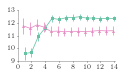

In [1456]:
plot_multiple_followers_perf(run_multiple_df=run_multiple_df, measure='top_1', 
                             file_name='multiple-followers-top-1.pdf',
                             yticks=[9, 10, 11, 12, 13])

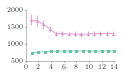

In [1457]:
plot_multiple_followers_perf(run_multiple_df=run_multiple_df, measure='avg_rank',
                            file_name='multiple-followers-average-rank.pdf',
                            yticks=[500, 1000, 1500, 2000])

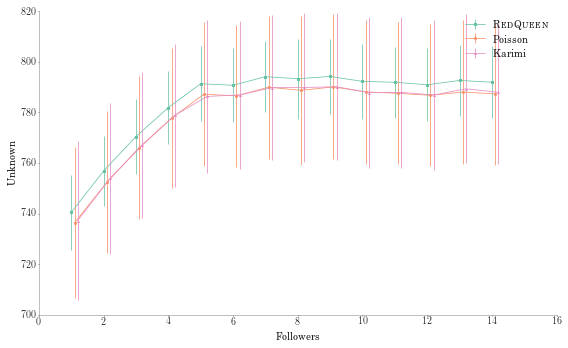

In [496]:
plot_multiple_followers_perf(run_multiple_df=run_multiple_df, measure='num_events')

What is the expected number of broadcasters covered with broadcaster pool = n and follower pool = m?

 - Can do it via simulation
 - Can do it by exact combinatorics

## Overlap between broadcasters

Keep the number of followers fixed at 2, each with 50 broadcasters and one optimal broadcaster. Then increase the overlap among the broadcasters and look at the performance.

In [ ]:
def plot_overlapping_perf(run_overlap_df, measure='avg_rank', 
                          yticks=None,
                          file_name=None):
    
    run_multiple_df = run_overlap_df.sort_values(['type', 'overlap'])
    perf_data_grp = run_overlap_df.groupby(['type', 'overlap'])
    perf_mean = perf_data_grp.mean()
    perf_std = perf_data_grp.std()
    
    # plt.figure(figsize=(8,6))
    
    if file_name is None:
        latexify(fig_width=8, largeFonts=True)
    else:
        latexify(fig_width=1.75, largeFonts=False)
    
    overlap = np.asarray(sorted(run_multiple_df.overlap.unique().tolist()))
    c1, c2, c3 = sns.color_palette('Set1', n_colors=3)
    
    plt.errorbar(overlap, perf_mean.ix['Opt'][measure].tolist(), fmt=red_queen_fmt,
                 yerr=perf_std.ix['Opt'][measure].tolist(), label=r'\textsc{RedQueen}',
                 linewidth=0.75, markersize=3, color=red_queen_color)
    
    plt.errorbar(overlap + 0.005, perf_mean.ix['Poisson'][measure].tolist(), fmt=poisson_fmt,
                 yerr=perf_std.ix['Poisson'][measure].tolist(), label='Poisson',
                 linewidth=0.75, markersize=3, color=poisson_color)
    
    plt.errorbar(overlap + 0.01, perf_mean.ix['kdd'][measure].tolist(), fmt=karimi_fmt,
                 yerr=perf_std.ix['kdd'][measure].tolist(), label='Karimi',
                 linewidth=0.75, markersize=3, color=karimi_color)
    
    if file_name is None:
        plt.xlabel('Overlap')

        ylabel = 'Unknown'

        if measure == 'avg_rank':
            ylabel = 'Average position'
            plt.legend(loc='upper right')
        elif measure == 'top_1':
            ylabel = r'$\int I(r(t) < 1)\,dt$'
            plt.legend(loc='lower right')
        else:
            plt.legend()

        plt.ylabel(ylabel)
        
    if yticks is not None:
        plt.yticks(yticks)
    
    plt.xlim((0, overlap.max() + 0.02))
    plt.tight_layout()
    format_axes(plt.gca())
    
    if file_name is not None:
        plt.savefig(os.path.join(plot_base, file_name), bbox_inches='tight', pad_inches=0)
    
    

In [22]:
from opt_runs import prepare_overlapping_followees_sim_opts, overlap_opts

In [23]:
overlap_sim_opts = prepare_overlapping_followees_sim_opts(num_overlap=10, opts=overlap_opts)

In [649]:
%run -i utils.py

In [619]:
import warnings

In [ ]:
%%time
num_broadcasters = 50
overlapping_run_opts = Options(overlap_list=range(0, num_broadcasters + 1), num_segments=24, repetitions=100,
                               setup_opts=overlap_opts.set(kind='PiecewiseConst', 
                                                           broadcasters_per_follower=num_broadcasters))
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    overlapping_res = run_overlapping_followees(opts=overlapping_run_opts)

In [ ]:
overlap_df = overlapping_res.df.copy()

In [ ]:
def sim_opts_overlap(sim_opts):
    followees = [set([s for s, t in sim_opts.edge_list if t == x]) for x in sim_opts.sink_ids]
    assert len(followees) == 2
    return (len(followees[0].intersection(followees[1])) - 1) / (len(followees[0]) - 1) # len(followees[0].union(followees[1]))

In [ ]:
overlap_df['overlap'] = [sim_opts_overlap(x['sim_opts']) for x in overlapping_res.raw_results]

In [ ]:
overlap_df.groupby(['type', 'overlap']).mean()

In [ ]:
plot_overlapping_perf(overlap_df, measure='avg_rank')

In [ ]:
plot_overlapping_perf(overlap_df, measure='top_1')

## Testing out significance

In [743]:
%run -i opt_model.py
%run -i utils.py

In [775]:
sim_opts = SimOpts(src_id=1, 
                  q_vec=np.asarray([1.0, 1.0]),
                  s=1.0, 
                  end_time=100,
                  other_sources=[('Poisson2', {'src_id': 1000, 'seed': 42, 'rate': 10.0}), 
                                 ('Poisson2', {'src_id': 1001, 'seed': 43, 'rate': 10.0})],
                  sink_ids = [5001, 5002],
                  edge_list=[(1, 5001), (1, 5002), (1000, 5001), (1001, 5002)])

In [776]:
%%time
opt_pw_mgr = sim_opts.create_manager_with_significance(1, time_period=10.0, num_segments=24)
opt_pw_mgr.run_dynamic()

opt_mgr = sim_opts.create_manager_with_opt(1)
opt_mgr.run_dynamic()

opt_pw_df = opt_pw_mgr.state.get_dataframe()
opt_df = opt_mgr.state.get_dataframe()

poisson_mgr = sim_opts.create_manager_with_poisson(45, capacity=num_tweets_of(opt_df, sim_opts=sim_opts))
poisson_mgr.run_dynamic()

poisson_df = poisson_mgr.state.get_dataframe()

CPU times: user 273 ms, sys: 13.3 ms, total: 287 ms
Wall time: 283 ms


In [777]:
print(num_tweets_of(opt_df, sim_opts=sim_opts), 
      num_tweets_of(opt_pw_df, sim_opts=sim_opts),
      num_tweets_of(poisson_df, sim_opts=sim_opts))
print(opt_df.shape, opt_pw_df.shape, poisson_df.shape)

(324.0, 325.0, 312.0)

The optimal and optimal-picewise should have similar performance.

In [779]:
print(time_in_top_k(opt_df, K=1, sim_opts=sim_opts), 
      time_in_top_k(opt_pw_df, sim_opts=sim_opts, K=1), 
      time_in_top_k(poisson_df, sim_opts=sim_opts, K=1))
print(average_rank(opt_df, sim_opts=sim_opts), 
      average_rank(opt_pw_df, sim_opts=sim_opts, K=1), 
      average_rank(poisson_df, sim_opts=sim_opts, K=1))

30.6505733464 29.6750640797 23.6733687659
172.614283682 171.548425075 316.374108601


### Change importance

In [780]:
sim_opts_unequal = sim_opts.update({'q_vec': np.asarray([0.5, 1.5])})

In [793]:
%%time
opt_pw_mgr = sim_opts_unequal.create_manager_with_significance(41, time_period=10.0, num_segments=24)
opt_pw_mgr.run_dynamic()

opt_mgr = sim_opts_unequal.create_manager_with_opt(1)
opt_mgr.run_dynamic()

opt_pw_df = opt_pw_mgr.state.get_dataframe()
opt_df = opt_mgr.state.get_dataframe()

poisson_mgr = sim_opts_unequal.create_manager_with_poisson(4, capacity=num_tweets_of(opt_df, sim_opts=sim_opts))
poisson_mgr.run_dynamic()

poisson_df = poisson_mgr.state.get_dataframe()

CPU times: user 273 ms, sys: 20 ms, total: 293 ms
Wall time: 289 ms


In [794]:
print(num_tweets_of(opt_df, sim_opts=sim_opts), 
      num_tweets_of(opt_pw_df, sim_opts=sim_opts), 
      num_tweets_of(poisson_df, sim_opts=sim_opts))
print(opt_df.shape, opt_pw_df.shape, poisson_df.shape)

325.0 323.0 336.0
(2594, 5) (2590, 5) (2616, 5)


In [795]:
print(time_in_top_k(opt_df, K=1, sim_opts=sim_opts), 
      time_in_top_k(opt_pw_df, sim_opts=sim_opts, K=1), 
      time_in_top_k(poisson_df, sim_opts=sim_opts, K=1))
print(average_rank(opt_df, sim_opts=sim_opts), 
      average_rank(opt_pw_df, sim_opts=sim_opts, K=1), 
      average_rank(poisson_df, sim_opts=sim_opts, K=1))

30.6124782772 30.2860675318 24.8904723685
171.651501755 172.651153777 299.409321481


### Setting significance

In [802]:
np.asarray([1,2,3]).reshape()

array([1, 2, 3])

In [847]:
num_segs = 24
sig = np.square(np.sin(np.arange(0, num_segs, step=1.0) * 4 * np.pi / num_segs))
sig = (sig / sig.sum()).reshape((1, -1))
sim_opts = SimOpts(src_id=1, 
                  q_vec=1.0,
                  s=1.0, 
                  end_time=100,
                  other_sources=[('Poisson2', {'src_id': 1000, 'seed': 42, 'rate': 500.0})],
                  sink_ids = [5001],
                  edge_list=[(1, 5001), (1000, 5001)])

In [848]:
%%time
opt_sig_mgr = sim_opts.create_manager_with_significance(seed=10, time_period=sim_opts.end_time, 
                                                        significance=sig)
opt_sig_mgr.run_dynamic()

CPU times: user 3.76 s, sys: 233 ms, total: 4 s
Wall time: 3.87 s


In [849]:
df = opt_sig_mgr.state.get_dataframe()

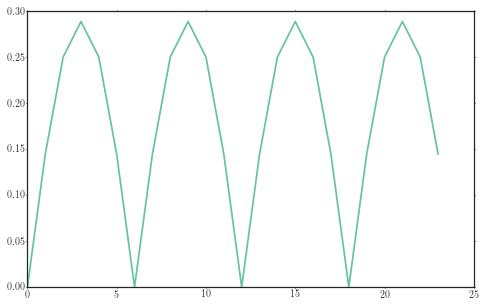

In [850]:
plt.plot(np.sqrt(sig.ravel()))

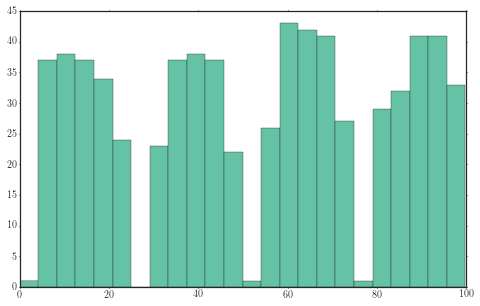

In [853]:
plt.hist(df.t[df.src_id == sim_opts.src_id].unique(), bins=num_segs);

## `s_init` heuristic

In [187]:
%run -i utils.py
%run -i opt_model.py

In [287]:
sim_opts = SimOpts.std_poisson(world_seed=1, world_rate=500)

In [288]:
sweep_s(lambda: sim_opts, 10, verbose=True, dynamic=True)

*** 2016-05-13 16:06:06.308683 Checkpoint: Initial capacity = 16.682815756349004, target capacity = 10
*** 2016-05-13 16:06:06.515228 Checkpoint: s = 2.0, capcity = 14.461590479654564
*** 2016-05-13 16:06:06.711105 Checkpoint: s = 4.0, capcity = 12.150333853228608
*** 2016-05-13 16:06:06.903814 Checkpoint: s = 8.0, capcity = 10.439782962439807
*** 2016-05-13 16:06:07.116908 Checkpoint: s = 16.0, capcity = 8.877513076274898
*** 2016-05-13 16:06:07.118326 Checkpoint: s_hi = 16.0, s_lo = 8.0
*** 2016-05-13 16:06:07.335871 Checkpoint: new_capacity = 9.554880390811231, s = 12.0


12.0

In [289]:
opt_mgr = sim_opts.update({ 's': 0.375 }).create_manager_with_opt(seed=1)
opt_mgr.run_dynamic()

In [290]:
opt_df = opt_mgr.state.get_dataframe()

In [291]:
opt_df[opt_df.src_id == sim_opts.src_id]

,event_id,sink_id,src_id,t,time_delta
0,100,1001,1,0.000000,0.000000
4,104,1001,1,0.002940,0.000070
32,132,1001,1,0.035653,0.001081
49,149,1001,1,0.077264,0.005290
60,160,1001,1,0.104315,0.001089
89,189,1001,1,0.155652,0.002980
105,205,1001,1,0.190397,0.001760
118,218,1001,1,0.214218,0.002258
137,237,1001,1,0.258508,0.001389
149,249,1001,1,0.275824,0.005616


In [292]:
wall_mgr = sim_opts.create_manager_for_wall()

In [293]:
wall_mgr.run_dynamic()

In [294]:
df = wall_mgr.state.get_dataframe()

In [295]:
r_t = rank_of_src_in_df(df, src_id=-1)

In [296]:
r_t.mean(1).iloc[-1]

495.0

In [297]:
df.shape

(495, 5)

In [298]:
(4 * (r_t.iloc[-1].mean() ** 2) * (sim_opts.end_time) ** 2) / (np.pi * np.pi * (10 + 1) ** 4) 

6.7826577479581491

In [60]:
hawkes_res.raw_results[-1
                      ]

{'avg_rank': 954.00681957353299,
 'broadcaster_events': 49,
 'num_events': 49,
 'r0_num_events': 49,
 'r_2': 13966.614080745609,
 's': 1000.0,
 'seed': 2,
 'sim_opts': <__main__.SimOpts at 0x7fc80895c358>,
 'top_1': 9.5668178314961985,
 'top_10': 52.303469506298647,
 'top_20': 90.47790271111036,
 'top_3': 20.567177074149754,
 'top_5': 30.583811352029109,
 'type': 'Oracle',
 'world_events': 1198}

In [58]:
[x['best_avg_k'] for x in hawkes_res.raw_results if x['type'] == 'KDD']

[]

# Run for user 52885404

In [866]:
base

'/NL/ghtorrent/work/opt-broadcast'

In [1219]:
user_id = 20712572

In [1220]:
# user_id = 35652801 s_opt = 3211150360.2065687
# s_opt = 155655.86986992834 for user_id = 52885404
user_raw = pickle.load(open(os.path.join(base, 'user-{}.pickle'.format(user_id)), 'rb'))

In [1221]:
user_result = revert_to_sim_opts(user_raw)

In [1222]:
user_raw.keys()

dict_keys(['user_id', 'num_user_events', 'scaled_period', 'user_event_times', 'sim_opts_dict'])

In [1223]:
sim_opts = user_result['sim_opts']

In [1224]:
user_raw.keys()

dict_keys(['user_id', 'num_user_events', 'scaled_period', 'user_event_times', 'sim_opts_dict'])

In [1225]:
s_opt = sweep_s(sim_opts, user_raw['num_user_events'], verbose=True)

*** 2016-08-04 19:15:05.918431 Checkpoint: s_init = 23432203434.13262
*** 2016-08-04 19:15:57.353308 Checkpoint: Initial capacity = 28.884668978252176, target capacity = 30, s_init = 23432203434.13262
*** 2016-08-04 19:16:48.425492 Checkpoint: s = 11716101717.06631, capacity = 35.039623937742554
*** 2016-08-04 19:16:48.426368 Checkpoint: s_hi = 23432203434.13262, s_lo = 11716101717.06631
*** 2016-08-04 19:17:39.959445 Checkpoint: new_capacity = 31.287997490987454, s = 17574152575.599464
*** 2016-08-04 19:18:31.115170 Checkpoint: new_capacity = 29.89889301925127, s = 20503178004.866043


In [1226]:
s_opt

20503178004.866043

In [1227]:
opt_mgr = sim_opts.update({'s': s_opt}).create_manager_with_opt(seed=1)

In [1228]:
%%time
opt_mgr.run_dynamic()

CPU times: user 34.5 s, sys: 640 ms, total: 35.2 s
Wall time: 35.2 s


In [1229]:
df_opt = opt_mgr.state.get_dataframe()

In [1230]:
user_id, sim_opts.src_id

(20712572, 20712572)

In [1231]:
real_mgr = sim_opts.update({'s': s_opt}).create_manager_with_times(event_times=user_result['user_event_times'])

In [1232]:
%%time
real_mgr.run_dynamic()

CPU times: user 5.5 s, sys: 123 ms, total: 5.62 s
Wall time: 5.63 s


In [1233]:
df_real = real_mgr.state.get_dataframe()

In [1234]:
df_opt.event_id[df_opt.src_id == user_id].nunique()

32

In [1235]:
df_real.event_id[df_real.src_id == user_id].nunique()

30

In [1236]:
%run -i utils.py

In [885]:
%%time
# seed, capacity, num_segments, sim_opts, world_changing_rates, queue = params
kdd_perf = worker_kdd((1, user_result['num_user_events'] * 1.0, 60, sim_opts, None, None), verbose=True, Ks=[1])

kdd_opt = kdd_perf['kdd_opt_1']

Traceback (most recent call last):
  File "/home/utkarshu/miniconda3/envs/py35/lib/python3.5/multiprocessing/queues.py", line 247, in _feed
    send_bytes(obj)
  File "/home/utkarshu/miniconda3/envs/py35/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/utkarshu/miniconda3/envs/py35/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/utkarshu/miniconda3/envs/py35/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
utils.py:736: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  follower_weights)


ValueError: domain error

In [1237]:
r_opt = rank_of_src_in_df(df_opt, user_id).mean(1)

In [1238]:
r_real = rank_of_src_in_df(df_real, user_id).mean(1)

In [1239]:
r_opt.shape

(606525,)

In [1240]:
r_opt_sampled = pd.concat([r_opt[::200], r_opt[r_opt == 0]]).sort_index()

In [1241]:
np.sum(r_opt == 0)

32

In [1242]:
df_real.t[df_real.src_id == user_id].unique()

array([  251.906,   441.235,   455.121,   886.766,  1413.65 ,  1429.583,
        1700.907,  2508.858,  2509.022,  2706.411,  3645.805,  3648.546,
        3993.621,  4269.935,  4305.957,  4306.243,  4309.272,  4313.168,
        4325.23 ,  4662.313,  5412.7  ,  5415.166,  5790.916,  5791.006,
        5799.317,  5809.817,  6078.444,  6099.087,  6207.644,  6854.717])

In [1243]:
r_real[(886.76 <= r_real.index) & (r_real.index <= 886.77)]

t
886.762619    775.066667
886.766353      0.016667
dtype: float64

In [1244]:
r_real[(r_real == 0)].index

Float64Index([ 251.90598865, 441.235439068, 455.120594385, 1413.64994026,
              1700.90725806, 2508.85790024, 2509.02217742, 3645.80533154,
              3993.62119176,  4269.9354092, 4305.95691458, 4306.24253286,
              4309.27232676, 4313.16830944,  4325.2296147, 4662.31332139,
              5412.69974612, 5415.16577061, 5790.91621864, 5791.00582437,
              5799.31675627, 5809.81742832, 6207.64448925, 6854.71736858],
             dtype='float64', name='t')

In [1245]:
r_real_sampled = pd.concat([r_real[::200], r_real[r_real == 0]]).sort_index()

The average rank of user among his followers.

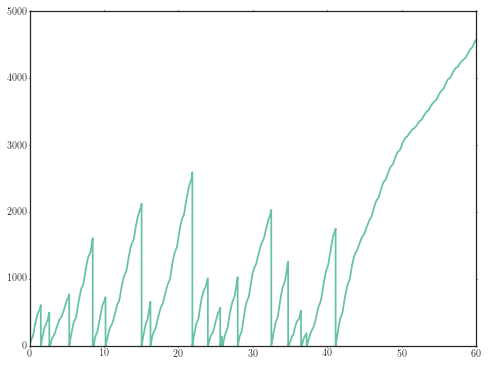

In [1246]:
latexify(fig_width=2.0, largeFonts=True)
plt.figure(figsize=(8,6))
plt.plot(60 * r_real_sampled.index / 10000, r_real_sampled.values)

In [1247]:
c1, c2, c3, c4 = sns.mpl_palette('Set2', 4)

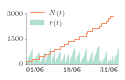

In [1470]:
latexify(fig_width=1.75, largeFonts=False)
# plt.figure(figsize=(8,6))
# plt.plot(60 * r_opt_sampled.index / 10000, r_opt_sampled.values, color=c1, linewidth=0.75)
one_month = r_opt_sampled.index <= 5000.0
ymin, ymax = 0, 3000

plt.fill_between(60 * r_opt_sampled.index[one_month] / 10000, r_opt_sampled.values[one_month], color=c1,
                 label=r'$\bar{r}(t)$',
                 alpha=0.5)

tweet_times = df_opt[(df_opt.src_id == sim_opts.src_id)].t.unique()
one_month_df = tweet_times < 5000.0
num_tweets = np.sum(one_month_df)

# plt.vlines(tweet_times[one_month_df] * 60 / 10000, ymin=0, ymax=1200, color=c2, linewidth=0.5)
plt.step(tweet_times[one_month_df] * 60 / 10000.0, np.arange(num_tweets) / num_tweets * ymax, 
         label='$N(t)$',
         color=c2, linewidth=1.0)

# plt.legend(loc="upper left")
plt.legend(bbox_to_anchor=(0.5, 1.2), bbox_transform=plt.gca().transAxes)

plt.yticks([0, 1500, 3000])
# plt.yticks([])
plt.xticks([3, 15, 27], ['01/06', '15/06', '31/06'])
plt.tight_layout()
format_axes(plt.gca())
plt.gca().xaxis.set_ticks_position('none')
# plt.savefig(os.path.join(plot_base, 'opt-data-counting.pdf'), bbox_inches='tight', pad_inches=0)

In [1465]:
tweet_times

array([], dtype=float64)

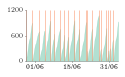

In [898]:
latexify(fig_width=1.75, largeFonts=False)
# plt.figure(figsize=(8,6))
# plt.plot(60 * r_opt_sampled.index / 10000, r_opt_sampled.values, color=c1, linewidth=0.75)
one_month = r_opt_sampled.index <= 5000.0
plt.fill_between(60 * r_opt_sampled.index[one_month] / 10000, r_opt_sampled.values[one_month], color=c1, alpha=0.5)

tweet_times = df_opt[(df_opt.src_id == user_id)].t.unique()
one_month_df = tweet_times < 5000.0
ymin, ymax = 0, 1200
plt.vlines(tweet_times[one_month_df] * 60 / 10000, ymin=0, ymax=1200, color=c2, linewidth=0.5)
plt.yticks([0, 600, 1200])
plt.xticks([3, 15, 27], ['01/06', '15/06', '31/06'])
plt.tight_layout()
format_axes(plt.gca())
# plt.savefig(os.path.join(plot_base, 'opt-data-ranks.pdf'), bbox_inches='tight', pad_inches=0)

In [899]:
np.sum(one_month_df)

20

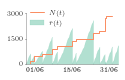

In [1469]:
latexify(fig_width=1.75, largeFonts=False)
# plt.figure(figsize=(8,6))
# plt.plot(60 * r_opt_sampled.index / 10000, r_opt_sampled.values, color=c1, linewidth=0.75)
one_month = r_real_sampled.index <= 5000.0
plt.fill_between(60 * r_real_sampled.index[one_month] / 10000, r_real_sampled.values[one_month], 
                 label=r'$\bar{r}(t)$', color=c1, alpha=0.5)

tweet_times = df_real[(df_real.src_id == sim_opts.src_id)].t.unique()
one_month_df = tweet_times < 5000.0
num_tweets = np.sum(one_month_df)
ymin, ymax = 0, 3000
# plt.vlines(tweet_times[one_month_df] * 60 / 10000, ymin=0, ymax=1200, color=c2, linewidth=0.5)
plt.step(tweet_times[one_month_df] * 60 / 10000.0, np.arange(num_tweets) / num_tweets * ymax, color=c2,
         label=r'$N(t)$',
         linewidth=1.0)

plt.yticks([0, 1500, 3000])
plt.xticks([3, 15, 27], ['01/06', '15/06', '31/06'])
# leg = plt.legend(loc="upper left")

# Get the bounding box of the original legend
# bb = leg.legendPatch.get_bbox().inverse_transformed(plt.gca().transAxes)
# leg.legendPatch.
plt.legend(bbox_to_anchor=(0.5, 1.2), bbox_transform=plt.gca().transAxes)

plt.tight_layout()
format_axes(plt.gca())
plt.gca().xaxis.set_ticks_position('none')
# plt.savefig(os.path.join(plot_base, 'real-data-counting.pdf'), bbox_inches='tight', pad_inches=0)

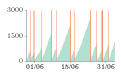

In [902]:
latexify(fig_width=1.75, largeFonts=False)
# plt.figure(figsize=(8,6))
# plt.plot(60 * r_real_sampled.index / 10000, r_real_sampled.values)
one_month = r_real_sampled.index <= 5000.0
plt.fill_between(60 * r_real_sampled.index[one_month] / 10000, r_real_sampled.values[one_month], color=c1, alpha=0.5)

tweet_times = df_real[(df_real.src_id == sim_opts.src_id)].t.unique()
one_month_df = tweet_times < 5000.0
plt.vlines(tweet_times[one_month_df] * 60 / 10000.0, ymin=0, ymax=3000, color=c2, linewidth=0.5)
plt.tight_layout()
plt.yticks([0, 1500, 3000]) # , [0, r'$10^3$', r'$3\times 10^3$'])
plt.xticks([3, 15, 27], ['01/06', '15/06', '31/06'])
format_axes(plt.gca())
# plt.savefig(os.path.join(plot_base, 'real-data-ranks.pdf'), bbox_inches='tight', pad_inches=0)

In [903]:
np.sum(one_month_df)

20

In [1362]:
%run -i real_data_gen.py
%run -i utils.py

In [963]:
hs = get_user_repository()

In [1363]:
expr_times = get_start_end_time()
scaling_factor = (expr_time.end_time - expr_time.start_time) / scaled_period
# num_segments = 6
# real_segment_len =  (60 * 60 * 24 / 6)

num_segments = 7
real_segment_len = 60 * 60 * 24

user_significance = find_significance(
    user_id=sim_opts.src_id, 
    user_repository=hs,
    num_segments=num_segments,
    segment_length=real_segment_len,
    return_tweet_times=True
)

sig_opts = Deco.Options(num_segments=num_segments, 
                        segment_length=real_segment_len / scaling_factor,
                        start_time=0)

In [1364]:
sig = user_significance.significance

In [1365]:
sig.shape

(30, 7)

Distribution of significance among the followers.

(array([ 13.,  25.,  22.,  31.,  17.,   9.,  24.]),
 array([ 0.   ,  0.857,  1.714,  2.571,  3.429,  4.286,  5.143,  6.   ]),
 <a list of 7 Patch objects>)

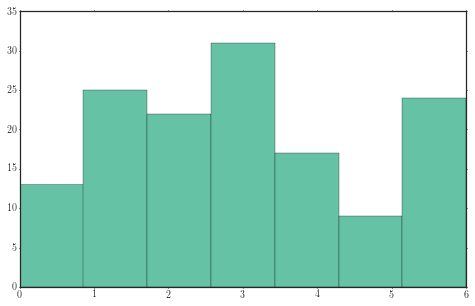

In [1366]:
plt.hist(convert_to_bins([x for x in hs.get_user_tweets(sim_opts.src_id) if x < expr_times.start_time], 
                         start_time=expr_times.start_time, 
                         num_segments=num_segments,
                         segment_length=real_segment_len), 
         bins=7)

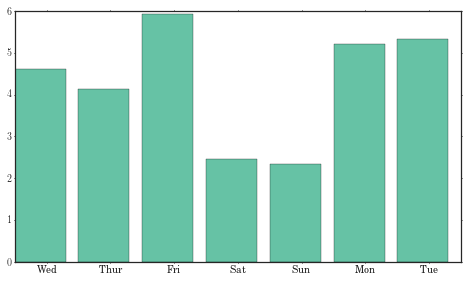

In [1368]:
plt.figure(figsize=(8,4.5))
plt.bar(range(num_segments), (user_significance.significance.sum(0)))
plt.xticks(np.arange(0.5, num_segments + 0.5), ['Wed', 'Thur', 'Fri', 'Sat', 'Sun', 'Mon', 'Tue']);

This is what the distribution of tweewts looked like without any significance.

In [1281]:
from datetime import datetime

In [1282]:
datetime.utcfromtimestamp

<function datetime.utcfromtimestamp>

In [1288]:
days = [datetime.utcfromtimestamp(x).weekday() for y in user_significance.all_tweet_times for x in y]

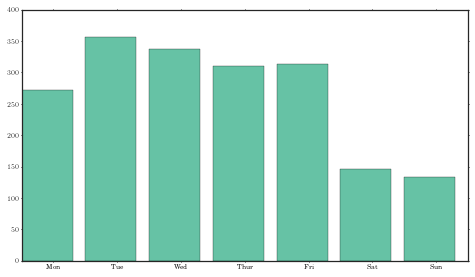

In [1291]:
plt.figure(figsize=(8,4.5))
plt.bar(range(num_segments), np.bincount(days))
plt.xticks(np.arange(0.5, num_segments + 0.5), ['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun']);

In [1037]:
df_opt.t[df_opt.src_id == sim_opts.src_id].unique() 

array([    0.   ,   341.478,   726.068,  1026.144,  1337.371,  1551.147,
        1864.017,  2095.041,  2313.458,  2644.116,  2905.501,  3268.387,
        3343.043,  3590.779,  3948.662,  4071.397,  4371.113,  4463.008,
        4568.638,  4715.002,  5201.879,  5719.893,  6063.347,  6171.623,
        6346.155,  6619.573,  6952.219,  7394.048,  7598.194,  8061.934,
        8700.188,  9633.311])

In [1038]:
sig_opts.segment_length

161.29032258064518

In [1001]:
%run -i utils.py

In [1040]:
convert_to_bins(df_opt.t[df_opt.src_id == sim_opts.src_id].unique(), opts=sig_opts)

time_period = 1129.0322580645163


array([0, 2, 4, 6, 1, 2, 4, 5, 0, 2, 4, 6, 6, 1, 3, 4, 6, 6, 0, 1, 4, 0, 2,
       3, 4, 6, 1, 3, 5, 0, 4, 3])

time_period = 1129.0322580645163


(array([ 5.,  4.,  4.,  4.,  7.,  2.,  6.]),
 array([ 0.   ,  0.857,  1.714,  2.571,  3.429,  4.286,  5.143,  6.   ]),
 <a list of 7 Patch objects>)

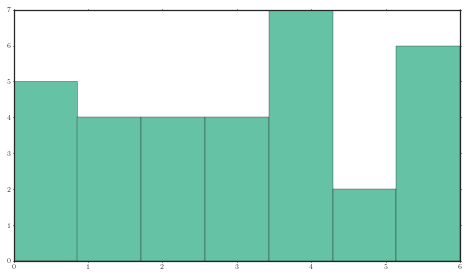

In [1041]:
plt.figure(figsize=(8,4.5))
plt.hist(convert_to_bins(df_opt.t[df_opt.src_id == sim_opts.src_id].unique(), opts=sig_opts), bins=num_segments)

The rank of the user in the feeds of his followers (in reality)

In [1042]:
average_rank(df_opt, sim_opts=sim_opts) / sim_opts.end_time

422.95381261988513

In [547]:
average_rank(df_real, sim_opts=sim_opts) / sim_opts.end_time

1387.4009282506947

In [940]:
user_id, sim_opts.src_id

(20712572, 20712572)

In [1043]:
len(sim_opts.sink_ids)

30

In [1292]:
%run -i utils.py
%run -i real_data_gen.py

In [1369]:
%%time
s_opt_sig = sweep_s_with_significance(
    sim_opts=sim_opts.update({ 'q_vec': sig }), 
    capacity_cap=df_real.event_id[df_real.src_id == sim_opts.src_id].nunique(),
    time_period=(7 * 24 * 60 * 60) / scaling_factor,
    parallel=True,
    verbose=True,
    s_init=3374237294515.0977
)

*** 2016-08-05 16:22:23.631316 Checkpoint: Initial capacity = 31.08, target capacity = 30, s_init = 2999322039568.9756
*** 2016-08-05 16:23:37.398815 Checkpoint: s = 5998644079137.951, capacity = 26.28
*** 2016-08-05 16:23:37.399612 Checkpoint: s_hi = 5998644079137.951, s_lo = 2999322039568.9756
*** 2016-08-05 16:24:54.201172 Checkpoint: new_capacity = 28.16, s = 4498983059353.463
*** 2016-08-05 16:26:09.619781 Checkpoint: new_capacity = 28.88, s = 3749152549461.219
*** 2016-08-05 16:27:23.752828 Checkpoint: new_capacity = 29.84, s = 3374237294515.0977
CPU times: user 797 ms, sys: 51.8 s, total: 52.6 s
Wall time: 6min 16s


This is the value that `s` should have for running with significance.

In [1384]:
s_opt_sig

3374237294515.0977

In [1370]:
sig_mgr = sim_opts.update({ 's': s_opt_sig, 'q_vec': sig }).create_manager_with_significance(
    seed=878,
    time_period=(7 * 24 * 60 * 60) / scaling_factor
)

In [1371]:
%%time
sig_mgr.run_dynamic()

CPU times: user 54.9 s, sys: 2.1 s, total: 57 s
Wall time: 56 s


In [1372]:
df_sig = sig_mgr.state.get_dataframe()
r_sig = rank_of_src_in_df(df_sig, sim_opts.src_id).mean(1)

In [1373]:
convert_to_bins(df_sig.t[df_sig.src_id == sim_opts.src_id].unique(), opts=sig_opts)

array([0, 1, 2, 6, 0, 0, 2, 5, 6, 1, 1, 3, 5, 6, 1, 2, 3, 0, 1, 2, 4, 6, 2,
       6, 1, 2, 4, 6, 4])

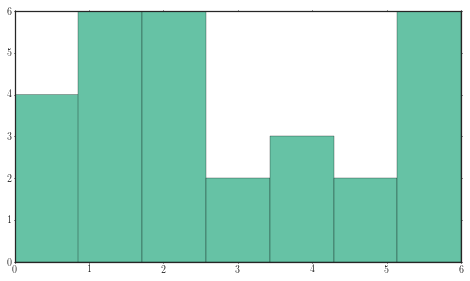

In [1374]:
plt.figure(figsize=(8,4.5))
expr_time = get_start_end_time()


plt.hist(convert_to_bins(df_sig.t[df_sig.src_id == sim_opts.src_id].unique(), opts=sig_opts),
         bins=num_segments);

In [1375]:
r_sig_sampled = pd.concat([r_sig[::200], r_sig[r_sig == 0]]).sort_index()

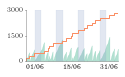

In [1468]:
latexify(fig_width=1.75, largeFonts=False)
# latexify(fig_width=8, largeFonts=True)
# plt.figure(figsize=(8,6))
# plt.plot(60 * r_opt_sampled.index / 10000, r_opt_sampled.values, color=c1, linewidth=0.75)
one_month = r_sig_sampled.index <= 5000.0
ymin, ymax = 0, 3000

plt.fill_between(60 * r_sig_sampled.index[one_month] / 10000, r_sig_sampled.values[one_month], color=c1,
                 label=r'$\bar{r}(t)$',
                 alpha=0.5)

tweet_times = df_sig[(df_sig.src_id == sim_opts.src_id)].t.unique()
one_month_df = tweet_times < 5000.0
num_tweets = np.sum(one_month_df)

# plt.vlines([7, 14, 21, 28], ymin=0, ymax=3000, color=c3, linewidth=0.75)
# plt.vlines(range(30), ymin=0, ymax=3000, color=c4, linewidth=0.5)

# Marking out the weekends.
plt.fill_between([3, 5], [ymax, ymax], color=c3, alpha=0.25)
plt.fill_between([10, 12], [ymax, ymax], color=c3, alpha=0.25)
plt.fill_between([17, 19], [ymax, ymax], color=c3, alpha=0.25)
plt.fill_between([24, 26], [ymax, ymax], color=c3, alpha=0.25)

plt.step(tweet_times[one_month_df] * 60 / 10000.0, np.arange(num_tweets) / num_tweets * ymax, 
         label='$N(t)$',
         color=c2, linewidth=1.0)

# plt.legend(loc="upper left")
# plt.legend(bbox_to_anchor=(0.5, 1.2), bbox_transform=plt.gca().transAxes)

plt.yticks([0, 1500, 3000])
plt.xticks([3, 15, 27], ['01/06', '15/06', '31/06'])
plt.tight_layout()
format_axes(plt.gca())
plt.gca().xaxis.set_ticks_position('none')
# plt.savefig(os.path.join(plot_base, 'sig-data-counting.pdf'), bbox_inches='tight', pad_inches=0)

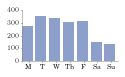

In [1407]:
# plt.figure(figsize=(8,4.5))
latexify(fig_width=1.75, largeFonts=False)
plt.bar(range(num_segments), (user_significance.raw_significance.sum(0))[[5, 6, 0, 1, 2, 3, 4]], color=c3, linewidth=0)
plt.xticks(np.arange(0.5, num_segments + 0.5), ['M', 'T', 'W', 'Th', 'F', 'Sa', 'Su']);
plt.yticks([0, 100, 200, 300, 400])
plt.tight_layout()
format_axes(plt.gca())
plt.savefig(os.path.join(plot_base, 'sig-week-day.pdf'), bbox_inches='tight', pad_inches=0)

In [1378]:
average_rank(df_opt[df_opt.t < 5000], end_time=5000, sim_opts=sim_opts) / sim_opts.end_time * 2

389.45432613518233

In [1379]:
average_rank(df_sig[df_sig.t < 5000], end_time=5000, sim_opts=sim_opts) / sim_opts.end_time * 2

425.25265231631306

In [1380]:
average_rank(df_real[df_real.t < 5000], end_time=5000, sim_opts=sim_opts) / sim_opts.end_time * 2

698.0467206055821

In [1381]:
df_opt[(df_opt.src_id == sim_opts.src_id) & (df_opt.t < 5000.0)].event_id.nunique()

20

In [1382]:
df_sig[(df_sig.src_id == sim_opts.src_id) & (df_sig.t < 5000.0)].event_id.nunique()

20

In [1383]:
df_real[(df_real.src_id == sim_opts.src_id) & (df_sig.t < 5000.0)].event_id.nunique()

20

In [1415]:
r_sig[r_sig.index < 5000].max()

1431.0

In [1416]:
r_opt[r_opt.index < 5000].max()

1085.1666666666667

In [1418]:
r_real[r_real.index < 5000].max()

2597.9000000000001